In [1]:
import os
import time
import requests
import random
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium import webdriver
from selenium.webdriver.support import expected_conditions as EC

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.preprocessing import image
from keras.utils import image_dataset_from_directory
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image

In [14]:
def create_folders(query):
    # Create the main "images" folder
    if not os.path.exists('images'):
        os.makedirs('images')

    # Create the training set folder within the "images" folder
    training_folder = os.path.join('images', 'training_set')
    if not os.path.exists(training_folder):
        os.makedirs(training_folder)

    # Create a folder within the training set folder with the query variable as its name
    query_training_folder = os.path.join(training_folder, query)
    if not os.path.exists(query_training_folder):
        os.makedirs(query_training_folder)

    # Create the test set folder within the "images" folder
    test_folder = os.path.join('images', 'test_set')
    if not os.path.exists(test_folder):
        os.makedirs(test_folder)

    # Create a folder within the test set folder with the query variable as its name
    query_test_folder = os.path.join(test_folder, query)
    if not os.path.exists(query_test_folder):
        os.makedirs(query_test_folder)

In [15]:
def download_images(image_urls, query, folder):

    for i, image_url in enumerate(image_urls):
        image_data = requests.get(image_url).content
        training_dir = os.path.join(query, "training_data")
        test_dir = os.path.join(query, "test_data")
        if random.random() <= 0.8:
            target_dir = os.path.join('images','training_set', folder)
            #with open(os.path.join(folder, f"{query}_{i}.jpg"), 'wb') as image_file:
            #    image_file.write(image_data)
        else:
            target_dir = os.path.join('images','test_set', folder)
        with open(os.path.join(target_dir, f"{query}_{i}.jpg"), 'wb') as image_file:
                image_file.write(image_data)


In [4]:
def scrape_images(query):
    driver = webdriver.Chrome()
    driver.get(f"https://www.google.com/search?q={query}&tbm=isch")
    for _ in range(10):
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(2)
    soup = BeautifulSoup(driver.page_source, 'lxml')

    driver.quit()

    img_tags = soup.findAll('img', class_='rg_i Q4LuWd')
    img_urls = []
  
    for img_tag in img_tags:
        if img_tag.has_attr('data-src'):
            img_urls.append(img_tag['data-src'])
    return list(img_urls)

  





In [37]:

#categories = ["city", "beach","forest","mountain","desert"]

categories = {
    'forest': ['forest','skog'],
    'city':['city','large city'],
    'beach': ['beach', 'strand'],
    'mountain': ['mountain','fjell'],
    'desert': ['desert', 'de woestijn']
    #'desert': ['desert','ørken']
}

redoDesert = {
    'desert': ['desert', 'de woestijn']
}

In [36]:
for key, values in categories.items():
    create_folders(key)
    for value in values:
        img_urls = scrape_images(value)
        download_images(img_urls,value, key)

In [38]:
for key, values in redoDesert.items():
    create_folders(key)
    for value in values:
        img_urls = scrape_images(value)
        download_images(img_urls,value, key)

# Create Model

In [2]:
NUM_CLASSES = 5

# Create a sequential model with a list of layers
model = tf.keras.Sequential([
  layers.Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation="relu"),
  layers.MaxPooling2D((2, 2)),
  layers.Dropout(0.2),
  layers.Conv2D(32, (3, 3), activation="relu"),
  layers.MaxPooling2D((2, 2)),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation="relu"),
  layers.Dense(NUM_CLASSES, activation="softmax") # because it's one class, we use sigmoid
])



In [3]:
# Compile and train your model as usual
model.compile(optimizer = optimizers.Adam(learning_rate=0.001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 32)        0

### Data Preprocessing and augmentation

In [4]:
NUM_CLASSES = 5
IMG_SIZE = 64
# There is no shearing option anymore, but there is a translation option
HEIGTH_FACTOR = 0.2
WIDTH_FACTOR = 0.2

# Create a sequential model with a list of layers
model = tf.keras.Sequential([
  # Add a resizing layer to resize the images to a consistent shape
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  # Add a rescaling layer to rescale the pixel values to the [0, 1] range
  layers.Rescaling(1./255),
  # Add some data augmentation layers to apply random transformations during training
  layers.RandomFlip("horizontal"),
  layers.RandomTranslation(HEIGTH_FACTOR,WIDTH_FACTOR),
  layers.RandomZoom(0.2),


  layers.RandomFlip("vertical"),
  
  layers.RandomContrast(0.2),

  #layers.RandomCrop(32,32),
  #layers.RandomBrightness(0.2),

  



  layers.Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation="relu"),
  layers.MaxPooling2D((2, 2)),
  layers.Dropout(0.2),
  layers.Conv2D(32, (3, 3), activation="relu"),
  layers.MaxPooling2D((2, 2)),
  layers.Dropout(0.2),
  layers.Flatten(), # Or, layers.GlobalAveragePooling2D()
  layers.Dense(128, activation="relu"),
  layers.Dense(NUM_CLASSES, activation="softmax")
])
checkpoint = ModelCheckpoint("saved_models/checkpoints/standardmodel/weights_{epoch:02d}.tf", save_weights_only=True, save_freq="epoch")
# Compile and train your model as usual
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [5]:
# Set the parameters for your data
batch_size = 32
image_size = (64, 64)
validation_split = 0.2

# Create the training dataset from the 'train' directory
train_ds = image_dataset_from_directory(
    directory='images/training_set',
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=image_size,
    validation_split=validation_split,
    subset='training',
    seed=123
)

# Create the validation dataset from the 'train' directory
validation_ds = image_dataset_from_directory(
    directory='images/training_set',
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=image_size,
    validation_split=validation_split,
    subset='validation',
    seed=123
)

# Create the testing dataset from the 'test' directory
test_ds = image_dataset_from_directory(
    directory='images/test_set',
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=image_size
)


Found 1602 files belonging to 5 classes.
Using 1282 files for training.
Found 1602 files belonging to 5 classes.
Using 320 files for validation.
Found 418 files belonging to 5 classes.


### Training and Validation

In [6]:
history = model.fit(train_ds,
                validation_data = validation_ds,
                steps_per_epoch = 41,
                epochs = 50,
                callbacks=[checkpoint]
                )

Epoch 1/50


41/41 [==============================] - 4s 73ms/step - loss: 1.4648 - accuracy: 0.3619 - val_loss: 1.2694 - val_accuracy: 0.5000
Epoch 2/50
41/41 [==============================] - 3s 72ms/step - loss: 1.2555 - accuracy: 0.4743 - val_loss: 1.1156 - val_accuracy: 0.5719
Epoch 3/50
41/41 [==============================] - 3s 74ms/step - loss: 1.2170 - accuracy: 0.4891 - val_loss: 1.0429 - val_accuracy: 0.5781
Epoch 4/50
41/41 [==============================] - 3s 71ms/step - loss: 1.1636 - accuracy: 0.5242 - val_loss: 1.0999 - val_accuracy: 0.5688
Epoch 5/50
41/41 [==============================] - 3s 67ms/step - loss: 1.1415 - accuracy: 0.5367 - val_loss: 1.0017 - val_accuracy: 0.5844
Epoch 6/50
41/41 [==============================] - 3s 66ms/step - loss: 1.1648 - accuracy: 0.5437 - val_loss: 0.9774 - val_accuracy: 0.6094
Epoch 7/50
41/41 [==============================] - 3s 66ms/step - loss: 1.1088 - accuracy: 0.5585 - val_loss: 0.9726 - val_accuracy: 0.6125
Epoch 8/50
41/41 [======

### Validation

In [7]:
model.save("modelSaved/savedmodel.tf")

INFO:tensorflow:Assets written to: modelSaved/savedmodel.tf\assets


INFO:tensorflow:Assets written to: modelSaved/savedmodel.tf\assets


In [2]:
from keras.models import load_model

model = load_model("modelSaved/savedmodel.tf")

NameError: name 'history' is not defined

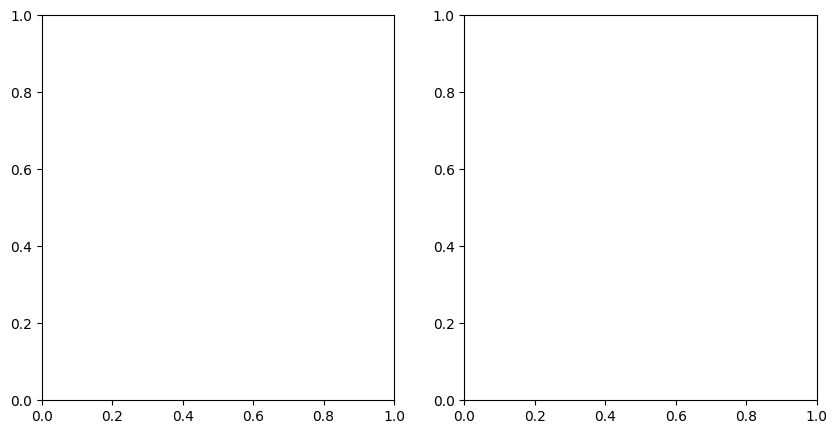

In [7]:
# Create a figure and a grid of subplots with a single call
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Plot the loss curves on the first subplot
ax1.plot(history.history['loss'], label='training loss')
ax1.plot(history.history['val_loss'], label='validation loss')
ax1.set_title('Loss curves')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot the accuracy curves on the second subplot
ax2.plot(history.history['accuracy'], label='training accuracy')
ax2.plot(history.history['val_accuracy'], label='validation accuracy')
ax2.set_title('Accuracy curves')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust the spacing between subplots
fig.tight_layout()

# Show the figure
plt.show()

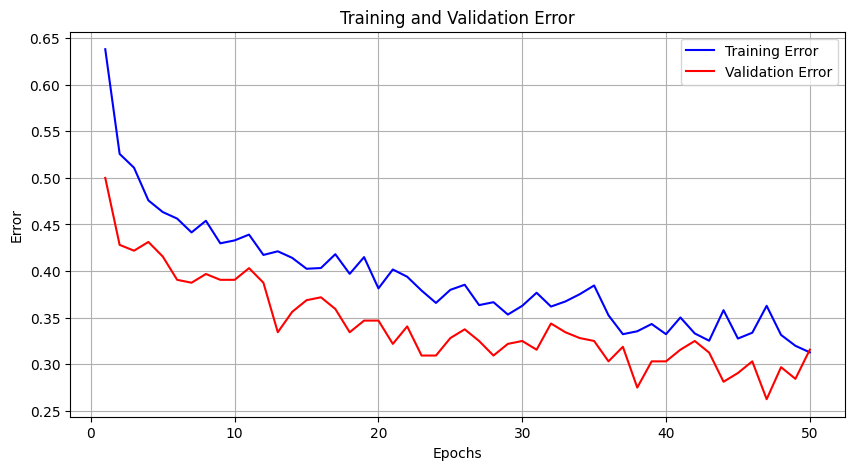

In [80]:
# Extract training and validation accuracy from the history object
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Calculate error (misclassification rate) by subtracting accuracy from 1
training_error = [1 - acc for acc in training_accuracy]
validation_error = [1 - acc for acc in validation_accuracy]

# Create a list of epoch numbers for x-axis
epochs = range(1, len(training_accuracy) + 1)

# Plot the training and validation error
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_error, 'b', label='Training Error')
plt.plot(epochs, validation_error, 'r', label='Validation Error')
plt.title('Training and Validation Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

### Prediction

In [3]:
epoch_nr = '42'

model.load_weights(f"saved_models/checkpoints/standardmodel/weights_{epoch_nr}.tf")


In [4]:
def predict_image(img):
    test_image = image.load_img(img, target_size=(64, 64))
    test_image = image.img_to_array(test_image)
    test_image = test_image / 255.0  # Ensure pixel values are in the [0, 1] range
    test_image = np.expand_dims(test_image, axis=0)
    class_names = train_ds.class_names
    # Use the model to predict the class
    predict = model.predict(test_image)

    predicted_class_index = np.argmax(predict[0])

    predicted_class_name = class_names[predicted_class_index]

    print(f"The model predicts class: {predicted_class_name}")

to_predict = "PredictionImages/dst.jpg"

predict_image(to_predict)


NameError: name 'train_ds' is not defined

### Confusion Matrix

In [6]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the image
img = image.load_img('PredictionImages/Torghatten-Norvegia-SOCIAL-1.jpg', target_size=image_size)
img_array = image.img_to_array(img)

# Our model was trained on images normalized to [0,1], so we need to normalize our input image too
img_array = img_array / 255.0
class_names = train_ds.class_names
# Models expect a batch of images as input, so we add an extra dimension
img_array = np.expand_dims(img_array, axis=0)

# Use the model to predict the class
predictions = model.predict(img_array)

# The output of the model is a softmax layer, we take the argmax to get the predicted class index
predicted_class = np.argmax(predictions[0])
predicted_class_name = class_names[predicted_class]
print(f"The model predicts class: {predicted_class_name}")

1/1 [==============================] - 0s 102ms/step
The model predicts class: mountain


In [7]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Create empty lists to store the true labels
true_labels = []

# Iterate through the test dataset to extract true labels
for images, labels in test_ds:
    true_labels.extend(np.argmax(labels, axis=1))

# Convert true_labels to a list or array
true_labels = list(true_labels)


In [8]:
predictions = model.predict(test_ds)
predicted_classes = np.argmax(predictions, axis=1)


14/14 [==============================] - 0s 12ms/step


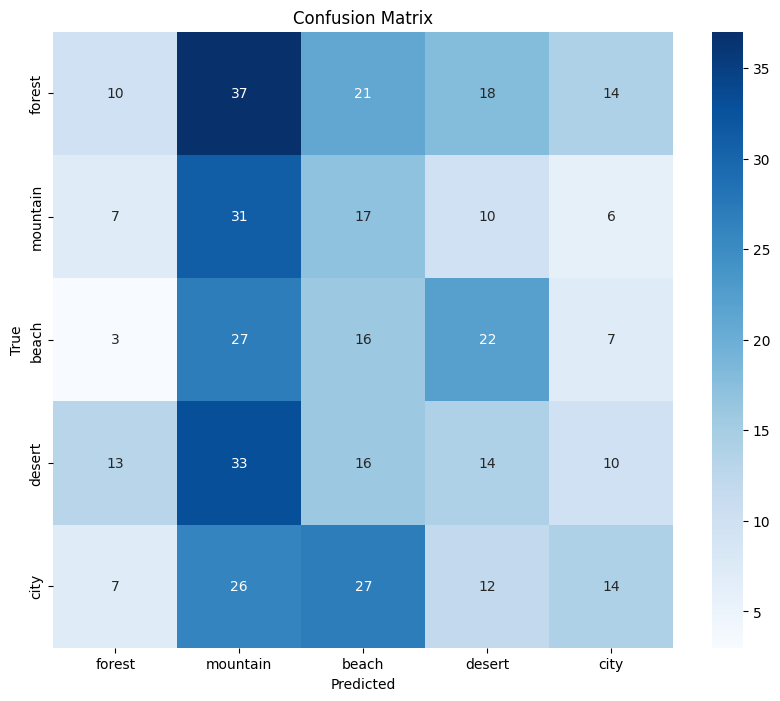

In [9]:
cm = confusion_matrix(true_labels, predicted_classes)

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["forest","mountain","beach","desert","city"], yticklabels=["forest","mountain","beach","desert","city"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Teachable Machine

Looking at the confusion matrix, it is clear that the model struggles the most to differenciate beach from the other categories, especially desert and forest. This is not too strange, as deserts and beaches both consist of sand, and beaches are often in close proimity to plants and cities.


Since this is the area where the model struggles the most it would be interesting to see how Googles Teachable Machine performes on the beach test data. A couple of images from the test set has been selected and we will in this section see what the model created in this task predicts vs Google Teachable Machine.


In [11]:
predict_image("./PredictionImages/beach_10.jpg")

1/1 [==============================] - 0s 18ms/step
The model predicts class: mountain
